In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
import re
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb

In [41]:
# 데이터 불러오기

od = pd.read_csv("taxonomy_data.csv",encoding='cp949')
od

,샘플이름,성별,키(m),몸무게(kg),BMI,나이,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;__;__,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__[Eubacterium]_coprostanoligenes_group;g__[Eubacterium]_coprostanoligenes_group;s__metagenome,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Cytophagales;f__Hymenobacteraceae;g__Hymenobacter;__,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Veillonellaceae;g__Dialister;__,...,d__Bacteria;p__Patescibacteria;c__Saccharimonadia;o__Saccharimonadales;f__LWQ8;g__LWQ8;s__uncultured_soil,d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Beijerinckiaceae;g__uncultured;s__uncultured_soil,d__Bacteria;p__Acidobacteriota;c__Blastocatellia;o__Pyrinomonadales;f__Pyrinomonadaceae;g__RB41;s__uncultivated_soil,d__Bacteria;p__Firmicutes;c__Clostridia;o__Christensenellales;f__Christensenellaceae;g__Christensenellaceae;s__Christensenella_sp.,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Chitinophagaceae;g__Flavisolibacter;__,d__Bacteria;p__Bdellovibrionota;c__Oligoflexia;o__Silvanigrellales;f__Silvanigrellaceae;__;__,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium_animalis,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__uncultured;s__unidentified,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__UCG-010;g__UCG-010;s__bacterium_enrichment,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinotignum;s__Actinotignum_schaalii
0,S0001,남,1.635,62.5,23.380000,57,0.022808,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,S0002,남,1.575,62.4,25.154951,63,0.020138,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,S0003,여,1.556,55.9,23.088335,63,0.025701,0.000000,0.0,0.000111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,S0004,여,1.667,67.3,24.218312,62,0.036104,0.002781,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,S0005,여,1.610,59.9,23.108676,43,0.026647,0.000000,0.0,0.034101,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506,S1507,여,1.612,76.5,29.439563,44,0.022308,0.000000,0.0,0.044838,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1507,S1508,남,1.753,79.8,25.968033,45,0.040610,0.002893,0.0,0.039497,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1508,S1509,남,1.722,71.6,24.146085,53,0.040832,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1509,S1510,여,1.546,44.0,18.409148,29,0.015131,0.021139,0.0,0.031041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# 추가 데이터 불러오기
ad = pd.read_csv("additional_data.csv",encoding='cp949')
ad.columns = ['id', 'chao1', 'shannon']
ad.head()

,id,chao1,shannon
0,S0001,184.000000,5.694573
1,S0002,272.500000,6.018361
2,S0003,192.583333,5.667854
3,S0004,164.142857,5.783435
4,S0005,240.000000,5.635428


In [43]:
# 두 데이터 merge 하기
df = pd.merge(od, ad, left_on = "샘플이름", right_on = "id", how = "left")
df = df.drop(['id'], axis = 1)

In [44]:
# 성별에 있는 공백 제거하기
df['성별'] = df['성별'].str.strip()

## 여자 BMI 예측

In [45]:
df_female = df.loc[df['성별'] == '여']

In [46]:
dfX = df_female[df.columns.difference(['샘플이름','키(m)', '몸무게(kg)', 'BMI', '성별'])]
dfy = df_female['BMI']

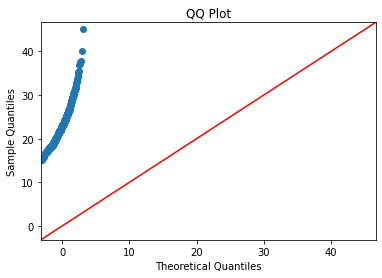

Shapiro-Wilk test p-value = 0.0000000000
KS test p-value = 0.0005254640


In [47]:
# Normality check

import statsmodels.api as sm
sm.qqplot(dfy, line="45")
plt.title('QQ Plot')
plt.show()

# Shapiro-Wilk test
stat, p = stats.shapiro(dfy)
print("Shapiro-Wilk test p-value = %.10f" % (p))

# Kolmogorov-Smirnov test
m = dfy.mean()
s = dfy.std()
stat, p = stats.kstest(dfy, 'norm', args = (m,s))
print("KS test p-value = %.10f" % (p))

Box-Cox lambda for x1 : -0.8452967692321335
Shapiro-Wilk test p-value = 0.8881226182
KS test p-value = 0.8166723077


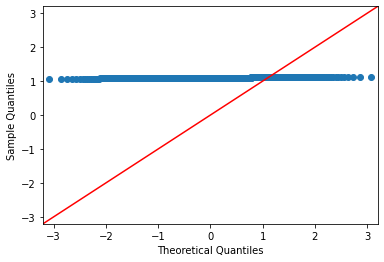

In [48]:
# Box-Cox Transformation

y  = np.array(dfy).reshape(-1)
y_most_normal, lmbda_optimal = stats.boxcox(y)
print("Box-Cox lambda for x1 : {}".format(lmbda_optimal))
#print("Transformed y by Box-Cox : {}".format(y_most_normal))

# qqplot
sm.qqplot(y_most_normal, line="45")

# Shapiro-Wilk test
stat, p = stats.shapiro(y_most_normal)
print("Shapiro-Wilk test p-value = %.10f" % (p))

# Kolmogorov-Smirnov test
m = y_most_normal.mean()
s = y_most_normal.std()
stat, p = stats.kstest(y_most_normal, 'norm', args = (m,s))
print("KS test p-value = %.10f" % (p))

## 값이 대부분 0인 predictors 제외하기

In [49]:
# 90% 이상이 zero value인 column list 만들기

column_list = dfX.columns.tolist()
zero_prop_list = []
for i in range(len(column_list)):
    zero_prop = len(dfX[column_list[i]].loc[dfX[column_list[i]] == 0]) / len(dfX)
    zero_prop_list.append(zero_prop)

df_prop = pd.DataFrame({"var" : column_list, "prop" : zero_prop_list})
zero_var_list = df_prop.loc[df_prop['prop'] >=0.9]['var'].tolist()

new_x_column_list = [element for element in column_list if element not in zero_var_list]

In [50]:
# 해당 컬럼 제외한 새로운 predictor data set 만들기 
dfX_new = dfX[new_x_column_list]

 ## Interaction term 추가

In [51]:
# 위의 feature들로 interaction 추가해보기
from sklearn.preprocessing import PolynomialFeatures

# add interaction terms (x1*x2, but not x1**2) for all remaining features
create_interactions = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)
X_poly = create_interactions.fit_transform(dfX_new)
X_poly = pd.DataFrame(X_poly,index=dfy.index)

In [52]:
# save info on which features contribute to each term in X_poly
powers = pd.DataFrame(create_interactions.powers_, columns = dfX_new.columns)
s = np.where(powers > 0, pd.Series(dfX_new.columns)+', ', '')
poly_terms = pd.Series([''.join(x).strip() for x in s])
X_poly.columns = poly_terms

## Interaction feature들이 누적 impotance가 90%이하인 feature만 선택하여 추가

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y_most_normal, random_state=12)

forest = RandomForestRegressor(max_depth = 11, max_features = "log2", random_state = 2)
forest.fit(X_train, y_train)

print("="*50)
print("Accuracy on Training set :{:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on Test set :{:.3f}".format(forest.score(X_test, y_test)))
print("="*50)


def re_trans(y, lmbda_optimal):
    result = (y*lmbda_optimal + 1)**(1/lmbda_optimal)
    return result

y_pred = forest.predict(X_test)
y_test_b = re_trans(y_test, lmbda_optimal)
y_pred_b = re_trans(y_pred, lmbda_optimal)

# MAE, MSE, RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("·MAE:",mean_absolute_error(y_test_b, y_pred_b))
print("·MSE:", mean_squared_error(y_test_b, y_pred_b))
print("·RMSE:", np.sqrt(mean_squared_error(y_test_b, y_pred_b)))
print("="*50)

Accuracy on Training set :0.501
Accuracy on Test set :0.046
·MAE: 2.8071771070905753
·MSE: 13.394843145266595
·RMSE: 3.6598966030841082


In [54]:
feature_imp_poly = pd.DataFrame({'features' : X_poly.columns, 'values' : forest.feature_importances_})
feature_imp_poly = feature_imp_poly.sort_values(by = 'values', ascending = False).reset_index().drop(['index'],axis=1)
feature_imp_poly['cum_prop']= feature_imp_poly['values'].cumsum() / feature_imp_poly['values'].sum()

In [55]:
feature_imp_poly['cum_prop'].loc[feature_imp_poly['cum_prop']<=0.9]

0       0.001761
1       0.003475
2       0.005021
3       0.006514
4       0.008005
          ...   
3520    0.899685
3521    0.899764
3522    0.899842
3523    0.899921
3524    0.899999
Name: cum_prop, Length: 3525, dtype: float64

In [56]:
most_imp_features = feature_imp_poly['features'].tolist()[0:3525]
X_poly_selected = X_poly[most_imp_features]
X_poly_selected = X_poly_selected.reset_index().drop(['index'],axis = 1)

In [57]:
X_poly_selected.head()

,"d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae;g__Erysipelatoclostridium;s__Massiliomicrobiota_timonensis, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Eubacterium]_eligens_group;__,","d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;__, d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinifilaceae;g__Odoribacter;__,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Ruminococcus]_gnavus_group;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__UCG-005;s__gut_metagenome,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Fusicatenibacter;s__uncultured_organism, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__UCG-010;g__UCG-010;s__gut_metagenome,","d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Christensenellales;f__Christensenellaceae;g__Christensenellaceae_R-7_group;s__uncultured_marine,","d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia;__,","d__Bacteria;__;__;__;__;__;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Eubacterium]_ventriosum_group;s__uncultured_Lachnospiraceae,","d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides_stercoris, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Marvinbryantia;__,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Dorea;s__uncultured_Dorea, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__[Eubacterium]_coprostanoligenes_group;g__[Eubacterium]_coprostanoligenes_group;s__human_gut,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Family_XI;g__Peptoniphilus;s__Peptoniphilus_lacrimalis, d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae;g__Sutterella;s__Sutterella_wadsworthensis,",...,"d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides_vulgatus, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__Oscillibacter;__,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter;s__Eubacterium_ramulus, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__UCG-002;__,","d__Bacteria;__;__;__;__;__;__, d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Holdemanella;s__uncultured_bacterium,","d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Eubacterium]_xylanophilum_group;s__uncultured_organism,","chao1, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__uncultured;s__human_gut,","d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides_stercoris, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__UCG-005;__,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__[Eubacterium]_siraeum_group;s__[Eubacterium]_siraeum, d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptococcales;f__Peptococcaceae;g__Peptococcus;s__uncultured_organism,","d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__DTU089;__,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Lachnospirac

## Interaction term을 PCA로 줄여서 넣어보기

In [58]:
from sklearn.preprocessing import StandardScaler  
x = X_poly.values 
y = dfy.values 
x = StandardScaler().fit_transform(x) 

features = X_poly.columns.tolist()
pd.DataFrame(x, columns=features).head()

,"chao1,","d__Bacteria;__;__;__;__;__;__,","d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;__,","d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium_bifidum,","d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium_dentium,","d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Rothia;__,","d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella;__,","d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Eggerthella;__,","d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Senegalimassilia;s__uncultured_bacterium,","d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Slackia;__,",...,"d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis;s__Victivallis_vadensis, d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__vadinBE97;g__vadinBE97;s__uncultured_rumen,","d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis;s__Victivallis_vadensis, d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__,","d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis;s__Victivallis_vadensis, shannon,","d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis;s__Victivallis_vadensis, 나이,","d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__vadinBE97;g__vadinBE97;s__uncultured_rumen, d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__,","d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__vadinBE97;g__vadinBE97;s__uncultured_rumen, shannon,","d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__vadinBE97;g__vadinBE97;s__uncultured_rumen, 나이,","d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__, shannon,","d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__, 나이,","shannon, 나이,"
0,-0.098563,-0.713467,0.230715,-0.173576,-0.21802,-0.073423,0.907089,-0.219933,-0.286836,-0.241482,...,-0.103401,-0.085908,-0.166461,-0.16677,-0.123069,-0.203473,-0.174798,-0.263660,-0.233423,0.694041
1,-0.515080,-0.713467,-0.225239,-0.173576,-0.21802,-0.073423,-0.298342,-0.219933,-0.286836,-0.241482,...,-0.103401,-0.085908,-0.166461,-0.16677,-0.123069,-0.203473,-0.174798,-0.265379,-0.235193,0.707200
2,0.595864,0.112203,-0.422019,0.106637,-0.21802,-0.073423,-0.418885,-0.219933,-0.062487,-0.241482,...,-0.103401,-0.085908,-0.166461,-0.16677,-0.123069,-0.203473,-0.174798,-0.090935,-0.111910,-0.313836
3,-1.329981,-0.713467,-0.306830,-0.173576,-0.21802,-0.073423,-0.532338,-0.219933,-0.286836,-0.241482,...,-0.103401,-0.085908,-0.166461,-0.16677,-0.123069,-0.203473,-0.174798,-0.265379,-0.235193,-0.549131
4,-1.334863,-0.595514,0.204318,-0.173576,-0.21802,-0.073423,-0.347977,-0.219933,-0.286836,-0.241482,...,-0.103401,-0.085908,-0.166461,-0.16677,-0.123069,-0.203473,-0.174798,-0.265379,-0.235193,-0.287691


In [59]:
from sklearn.decomposition import PCA
# Create principal components
pca = PCA()
X_pca = pca.fit_transform(x)
# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
print('X_pca shape', X_pca.shape)
X_pca.head()

X_pca shape (964, 964)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC955,PC956,PC957,PC958,PC959,PC960,PC961,PC962,PC963,PC964
0,-16.346844,-14.034351,0.154092,-4.326620,3.901627,7.360996,0.357615,0.712842,1.706176,16.828870,...,0.015996,-0.016942,0.032716,0.038302,0.009576,0.023083,0.009916,0.016344,0.010420,7.050204e-14
1,-19.781864,-6.316042,5.613187,-1.470410,3.145179,3.728509,6.948592,1.618026,-3.855019,15.114754,...,0.041505,0.025893,-0.013549,-0.094649,-0.228155,-0.018201,0.195315,0.070997,0.092819,7.050204e-14
2,2.204076,-25.073052,10.936030,-5.882833,-3.293481,4.711386,-3.438225,-3.701276,8.163246,6.628593,...,-0.027106,-0.014047,0.017617,0.012032,0.024107,0.060327,-0.016537,0.002201,0.009643,7.050204e-14
3,-21.771136,18.508137,17.630759,8.913301,6.181234,0.253754,-6.819516,7.287345,-14.768356,-13.524809,...,0.174325,0.012706,0.010395,-0.002018,0.138770,-0.011675,0.045824,0.010522,-0.040860,7.050204e-14
4,-20.260153,11.878205,19.532894,0.334495,2.823656,-6.459380,-2.110643,2.538081,-10.606847,-7.010574,...,0.028954,0.003258,-0.041466,0.034697,-0.044502,0.022923,0.004109,-0.012299,0.042628,7.050204e-14


In [60]:
X_pca_inter = X_pca.iloc[:,0:50]
X_pca_inter
dfX_pca = pd.concat([X_poly_selected, X_pca_inter], axis = 1)
dfX_pca.head()

,"d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae;g__Erysipelatoclostridium;s__Massiliomicrobiota_timonensis, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Eubacterium]_eligens_group;__,","d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;__, d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinifilaceae;g__Odoribacter;__,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Ruminococcus]_gnavus_group;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__UCG-005;s__gut_metagenome,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Fusicatenibacter;s__uncultured_organism, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__UCG-010;g__UCG-010;s__gut_metagenome,","d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Christensenellales;f__Christensenellaceae;g__Christensenellaceae_R-7_group;s__uncultured_marine,","d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia;__,","d__Bacteria;__;__;__;__;__;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Eubacterium]_ventriosum_group;s__uncultured_Lachnospiraceae,","d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides_stercoris, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Marvinbryantia;__,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Dorea;s__uncultured_Dorea, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__[Eubacterium]_coprostanoligenes_group;g__[Eubacterium]_coprostanoligenes_group;s__human_gut,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Family_XI;g__Peptoniphilus;s__Peptoniphilus_lacrimalis, d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae;g__Sutterella;s__Sutterella_wadsworthensis,",...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.802844,-6.623956,8.627349,3.859797,-9.763786,4.138771,9.322024,10.028617,2.734028,1.832894
1,0.000002,0.000008,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,-2.347264,2.006169,-0.917459,0.670737,-0.151393,-2.457285,0.023851,6.176687,-0.100457,4.688351
2,0.000000,0.000003,0.0,0.0,7.732531e-08,0.0,4.330217e-08,1.733014e-07,1.299758e-07,0.0,...,-3.788862,4.699155,0.743529,6.988523,-4.289472,1.118716,5.478642,3.438635,-6.261984,-6.405907
3,0.000000,0.000020,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,1.639440,-9.685082,-2.354766,1.374129,-5.121818,-10.551357,5.600559,1.116194,3.777326,0.606447
4,0.000000,0.000031,0.0,0.0,0.000000e+00,0.0,3.280334e-07,9.952452e-06,0.000000e+00,0.0,...,-9.783682,-5.530605,-4.403996,-19.644215,-2.950335,-10.051302,18.244836,-4.785773,-5.899456,10.412893


## Best train-test split

### Random Forest

In [25]:
def rf_model(X_train, y_train, X_test, y_test):
    # random forest

    forest = RandomForestRegressor(max_depth = 11, max_features = "log2", random_state = 2)
    forest.fit(X_train, y_train)

    #print("="*50)
    #print("Accuracy on Training set :{:.3f}".format(forest.score(X_train, y_train)))
    #print("Accuracy on Test set :{:.3f}".format(forest.score(X_test, y_test)))
    #print("="*50)


    def re_trans(y, lmbda_optimal):
        result = (y*lmbda_optimal + 1)**(1/lmbda_optimal)
        return result

    y_pred = forest.predict(X_test)
    y_test_b = re_trans(y_test, lmbda_optimal)
    y_pred_b = re_trans(y_pred, lmbda_optimal)

    # MAE, MSE, RMSE
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    #print("·MAE:",mean_absolute_error(y_test_b, y_pred_b))
    #print("·MSE:", mean_squared_error(y_test_b, y_pred_b))
    #print("·RMSE:", np.sqrt(mean_squared_error(y_test_b, y_pred_b)))
    #print("="*50)
    MAE = mean_absolute_error(y_test_b, y_pred_b)
    
    return MAE
    

In [26]:
mae_list = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(dfX_pca, y_most_normal, random_state=i)
    mae = rf_model(X_train, y_train, X_test, y_test)
    mae_list.append(mae)

In [27]:
pd.DataFrame({'mae' : mae_list}).sort_values(by='mae')

,mae
68,2.343834
63,2.420192
53,2.451252
32,2.457235
43,2.483082
...,...
77,2.860430
19,2.889539
55,2.915056
69,2.959229


In [61]:
# Best_train_test_set_split : random_state = 68

X_train, X_test, y_train, y_test = train_test_split(dfX_pca, y_most_normal, random_state = 68)

forest = RandomForestRegressor(max_depth = 11, max_features = "log2", random_state = 2)
forest.fit(X_train, y_train)

print("="*50)
print("Accuracy on Training set :{:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on Test set :{:.3f}".format(forest.score(X_test, y_test)))
print("="*50)

y_pred = forest.predict(X_test)
y_test_b = re_trans(y_test, lmbda_optimal)
y_pred_b = re_trans(y_pred, lmbda_optimal)

# MAE, MSE, RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("·MAE:",mean_absolute_error(y_test_b, y_pred_b))
print("·MSE:", mean_squared_error(y_test_b, y_pred_b))
print("·RMSE:", np.sqrt(mean_squared_error(y_test_b, y_pred_b)))
print("="*50)

Accuracy on Training set :0.589
Accuracy on Test set :0.032
·MAE: 2.343833616727971
·MSE: 9.425771846949214
·RMSE: 3.0701419913334975


Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from current font.
Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.


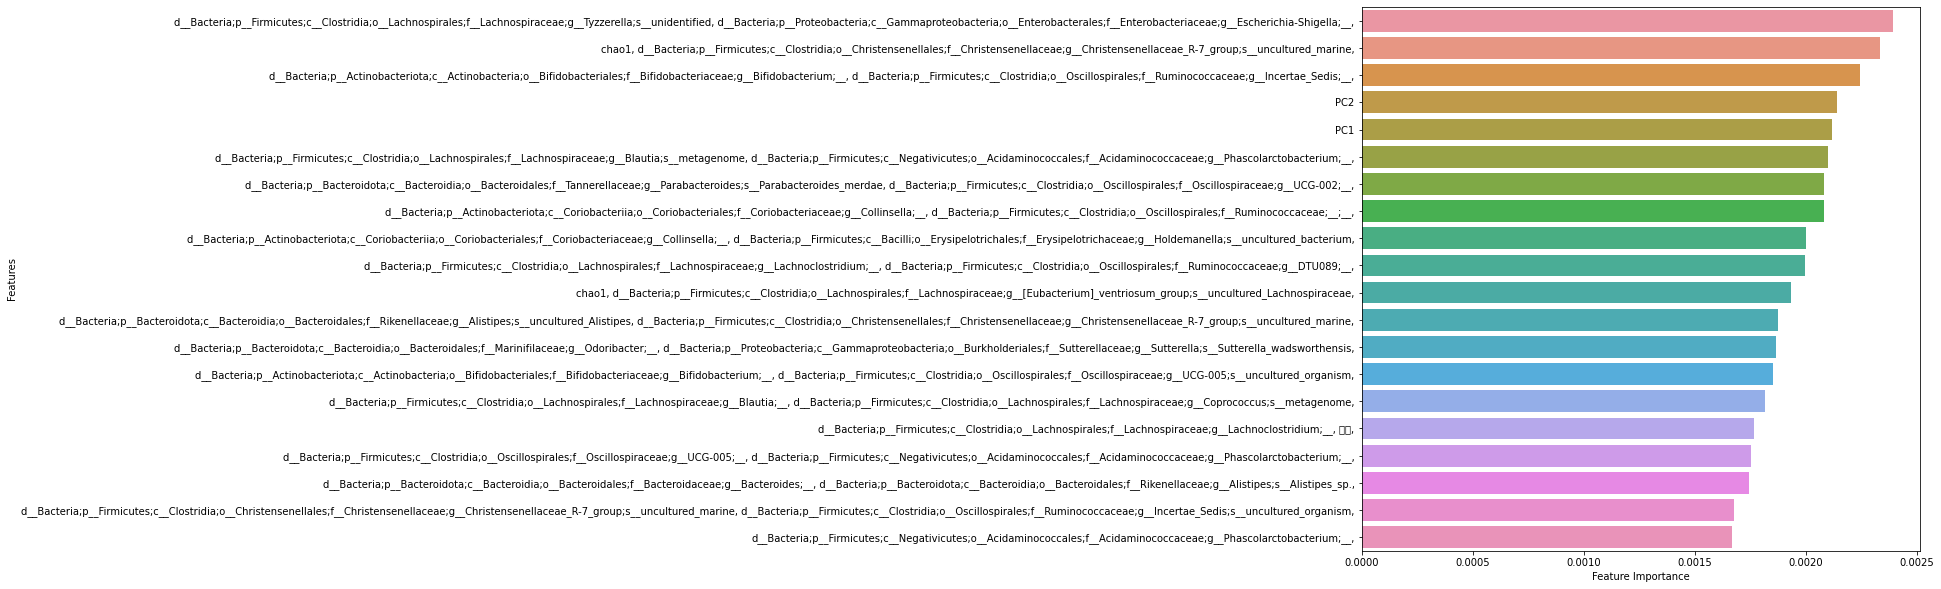

In [68]:
# Model Feature importance

feature_imp = pd.DataFrame({'Features' : forest.feature_names_in_, 'Feature Importance' : forest.feature_importances_})
feature_imp = feature_imp.sort_values(by = 'Feature Importance', ascending = False).reset_index(drop = True)

plt.figure(figsize= (10,10))
sns.barplot(x = 'Feature Importance', y = 'Features', data = feature_imp[0:20])
plt.show()

### SHAP Importance

In [63]:
import shap

In [64]:
# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(X_importance)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from current font.
Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from current font.
Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.


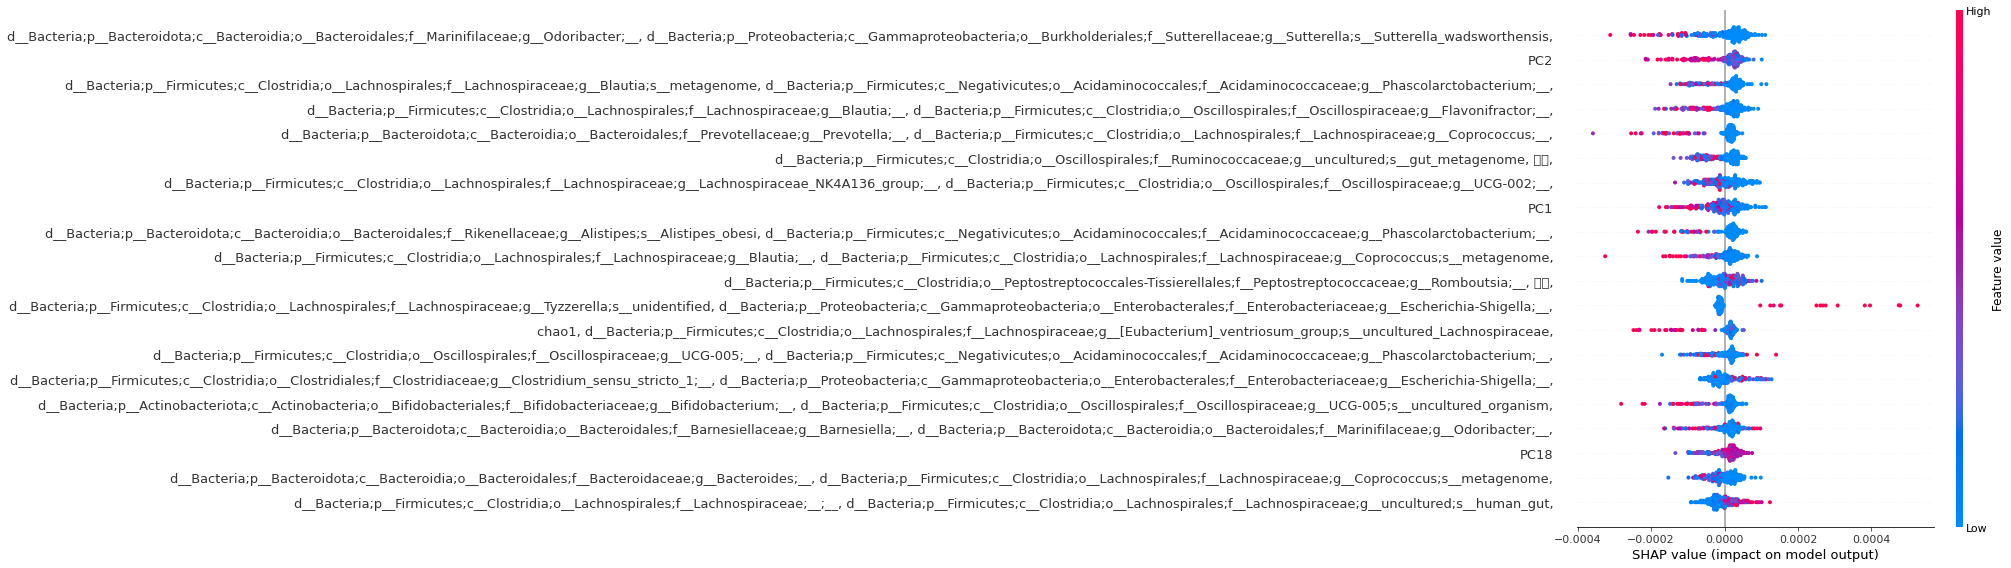

In [65]:
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

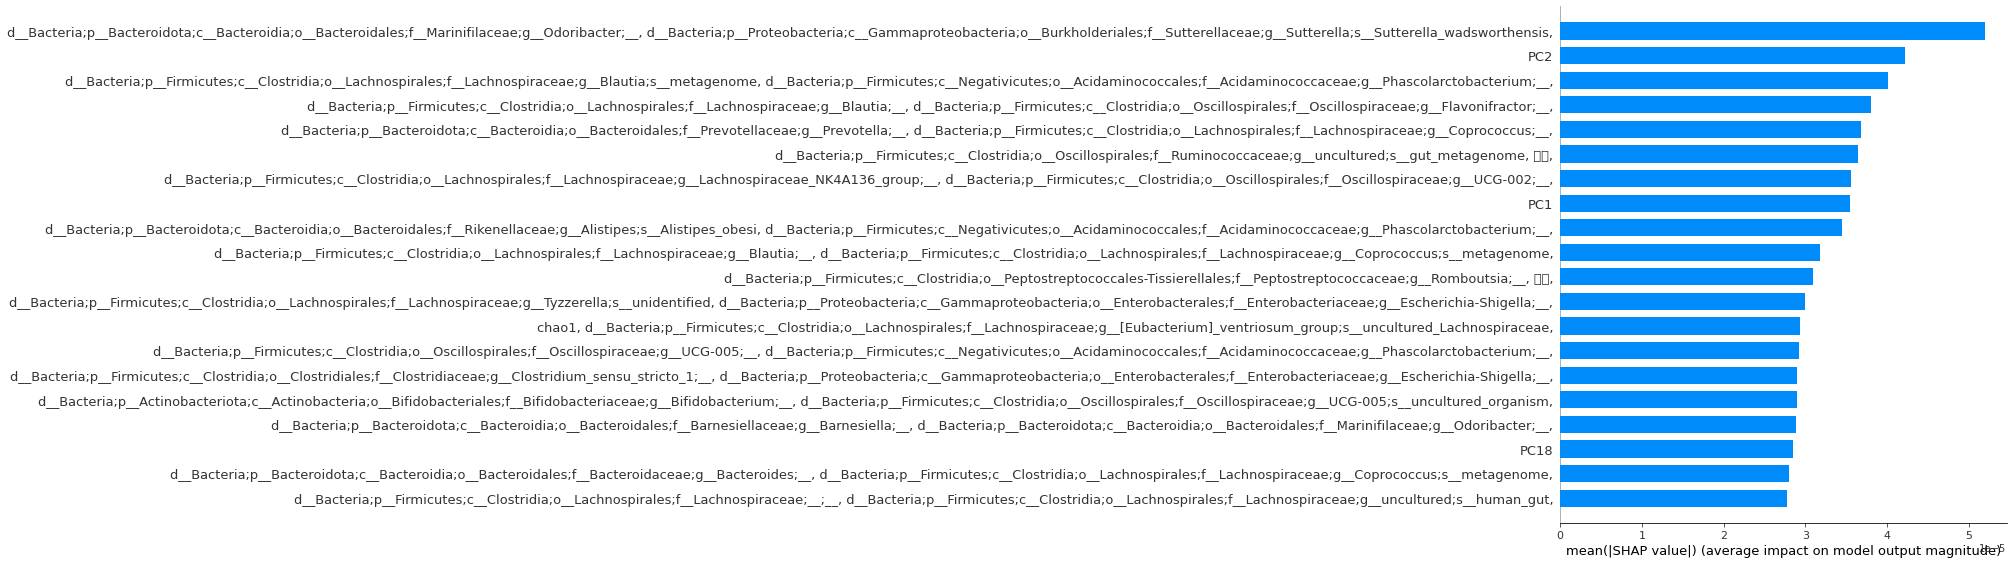

In [66]:
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

In [67]:
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)

# Model feature importance와 Shap importance 중 겹치는 것. 

set(feature_imp['Features'][0:20].tolist()) & set(importance_df['column_name'][0:20].tolist())

{'PC1',
 'PC2',
 'chao1, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Eubacterium]_ventriosum_group;s__uncultured_Lachnospiraceae,',
 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__UCG-005;s__uncultured_organism,',
 'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinifilaceae;g__Odoribacter;__, d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae;g__Sutterella;s__Sutterella_wadsworthensis,',
 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Coprococcus;s__metagenome,',
 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia;s__metagenome, d__Bacteria;p__Firmicutes;c__Negativicutes;o__Acidamin

### XGboost

In [28]:
# xgboost

def xgbmodel(dfX, dfy, random_state):
    
    X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, random_state=random_state)

    regex = re.compile(r"\[|\]|<", re.IGNORECASE)
    X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
    X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

    xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror', random_state =0)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    #feature_importance = xgb_model.feature_importances_

    #Print("="*50)
    #print('·train score:',xgb_model.score(X_train, y_train))
    #print('·validation score:',xgb_model.score(X_test, y_test))

    # Box-cox transformation 역변환
    def re_trans(y, lmbda_optimal):
        result = (y*lmbda_optimal + 1)**(1/lmbda_optimal)
        return result

    y_test = re_trans(y_test, lmbda_optimal)
    y_pred = re_trans(y_pred, lmbda_optimal)

    #print("·MAE:", mean_absolute_error(y_test, y_pred))
    #print("·MSE:", mean_squared_error(y_test, y_pred))
    #print("·RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    #print("="*50)
    MAE = mean_absolute_error(y_test, y_pred)
    return MAE

In [29]:
mae_list_xgb = []
for i in range(100):
    mae = xgbmodel(dfX_pca, y_most_normal, i)
    mae_list_xgb.append(mae)

In [30]:
pd.DataFrame({'mae' : mae_list_xgb}).sort_values(by='mae')

,mae
68,2.528466
4,2.578318
39,2.630902
21,2.642791
53,2.643113
...,...
19,3.082552
66,3.098495
16,3.129058
59,3.142707


### lightGBM

In [31]:
component_names = [f"feature{i+1}" for i in range(dfX_pca.shape[1])]
dfX_pca_lgb = dfX_pca.copy()
dfX_pca_lgb.columns = component_names
dfX_pca_lgb.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature3566,feature3567,feature3568,feature3569,feature3570,feature3571,feature3572,feature3573,feature3574,feature3575
0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.802844,-6.623956,8.627349,3.859797,-9.763786,4.138771,9.322024,10.028617,2.734028,1.832894
1,0.000002,0.000008,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,-2.347264,2.006169,-0.917459,0.670737,-0.151393,-2.457285,0.023851,6.176687,-0.100457,4.688351
2,0.000000,0.000003,0.0,0.0,7.732531e-08,0.0,4.330217e-08,1.733014e-07,1.299758e-07,0.0,...,-3.788862,4.699155,0.743529,6.988523,-4.289472,1.118716,5.478642,3.438635,-6.261984,-6.405907
3,0.000000,0.000020,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,1.639440,-9.685082,-2.354766,1.374129,-5.121818,-10.551357,5.600559,1.116194,3.777326,0.606447
4,0.000000,0.000031,0.0,0.0,0.000000e+00,0.0,3.280334e-07,9.952452e-06,0.000000e+00,0.0,...,-9.783682,-5.530605,-4.403996,-19.644215,-2.950335,-10.051302,18.244836,-4.785773,-5.899456,10.412893


In [32]:
# lightgbm

def lightgbm_model(dfX, dfy, random_state):
    
    dfX = dfX.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    X_train, X_test, y_train, y_test = train_test_split(dfX, dfy ,random_state = random_state)

    model = lgb.LGBMRegressor(random_state = 0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #print('='*50)
    #print("Best model train set score : {}".format(model.score(X_train, y_train)))
    #print("Best model test set score : {}".format(model.score(X_test, y_test)))
    #print('='*50)

    # Box-cox transformation 역변환
    def re_trans(y, lmbda_optimal):
        result = (y*lmbda_optimal + 1)**(1/lmbda_optimal)
        return result

    y_test = re_trans(y_test, lmbda_optimal)
    y_pred = re_trans(y_pred, lmbda_optimal)

    #print("·MAE:", mean_absolute_error(y_test, y_pred))
    #print("·MSE:", mean_squared_error(y_test, y_pred))
    #print("·RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    #print("="*50)
    
    MAE = mean_absolute_error(y_test, y_pred)
    return MAE
    

In [33]:
mae_list_lgb = []
for i in range(100):
    mae = lightgbm_model(dfX_pca_lgb, y_most_normal, i)
    mae_list_lgb.append(mae)

In [34]:
pd.DataFrame({'mae' : mae_list_lgb}).sort_values(by='mae')

,mae
68,2.326818
63,2.464491
43,2.479651
39,2.491579
17,2.498703
...,...
66,2.920266
58,2.928809
55,2.940364
85,2.957716


## K-fold cross validation

In [35]:
from sklearn.model_selection import KFold

In [36]:
# Random Forest

kf = KFold(n_splits = 5, shuffle= True)

X = dfX_pca.copy()
y = y_most_normal.copy()

test_mae_total_rf = []
for train_index, test_index in kf.split(X):
    # X_train, X_test 정의
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = RandomForestRegressor(max_depth = 11, max_features = "log2", random_state = 2)
    model.fit(X_train, y_train)
    
    #train_pred = model.predict(X_train) # 훈련셋 예측
    test_pred = model.predict(X_test) # 시험셋 예측
    
    def re_trans(y, lmbda_optimal):
        result = (y*lmbda_optimal + 1)**(1/lmbda_optimal)
        return result
    
    y_test = re_trans(y_test, lmbda_optimal)
    y_pred = re_trans(test_pred, lmbda_optimal)

    test_mae = mean_absolute_error(y_test, y_pred)
    test_mae_total_rf.append(test_mae)

print(test_mae_total_rf)
print(np.mean(test_mae_total_rf))


[2.688911575912939, 2.998373723613227, 2.54059890567861, 2.357501534784021, 2.6888037221767718]
2.6548378924331137


In [37]:
# xgboost

kf = KFold(n_splits = 5, shuffle= True)

X = dfX_pca.copy()
y = y_most_normal.copy()

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

train_mae_total = []
test_mae_total = []
for train_index, test_index in kf.split(X):
    # X_train, X_test 정의
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = xgb.XGBRegressor(objective = 'reg:squarederror', random_state = 0)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train) # 훈련셋 예측
    test_pred = model.predict(X_test) # 시험셋 예측
    
    def re_trans(y, lmbda_optimal):
        result = (y*lmbda_optimal + 1)**(1/lmbda_optimal)
        return result
    
    y_test = re_trans(y_test, lmbda_optimal)
    y_pred = re_trans(test_pred, lmbda_optimal)

    test_mae = mean_absolute_error(y_test, y_pred)
    test_mae_total.append(test_mae)

print(test_mae_total)
print(np.mean(test_mae_total))

[2.6452203727616483, 2.782200738422394, 2.804791933726066, 2.931221659936292, 2.862592450639316]
2.805205431097143


In [38]:
# lightgbm

kf = KFold(n_splits = 5, shuffle= True)

X = dfX_pca_lgb.copy()
y = y_most_normal.copy()

X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

train_mae_total = []
test_mae_total = []
for train_index, test_index in kf.split(X):
    # X_train, X_test 정의
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = lgb.LGBMRegressor(random_state = 0)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train) # 훈련셋 예측
    test_pred = model.predict(X_test) # 시험셋 예측
    
    def re_trans(y, lmbda_optimal):
        result = (y*lmbda_optimal + 1)**(1/lmbda_optimal)
        return result
    
    y_test = re_trans(y_test, lmbda_optimal)
    y_pred = re_trans(test_pred, lmbda_optimal)

    test_mae = mean_absolute_error(y_test, y_pred)
    test_mae_total.append(test_mae)

print(test_mae_total)
print(np.mean(test_mae_total))

[2.957407255072818, 2.542835850699282, 2.5325329869644433, 2.747684627190795, 2.787491802906548]
2.713590504566777
